Multilayer neural networks are a current hot-topic in machine learning. The multilayer perceptron was the first standardized architecture.  In this assignment, you will learn to tune a [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) model.

There are many libraries for using neural networks, but there isn't yet a single standard.  [Tensorflow](https://www.tensorflow.org/) is used by many, with [Keras](https://keras.io/) as one of the official APIs.


## Part 1: Installation, and Introduction to Keras

We'll be installing Keras and Tensorflow using a Docker container.  You could install Tensorflow natively (see [here](https://www.tensorflow.org/install/pip)) but Tensforflow typically causes downgrades in the Anaconda environment, and it has screwed up students'  Anaconda distribution in the past.

**NOTE** If you have a PC with an NVIDIA GPU, and you want to train on it (highly recommended if you're pursuing a neural-net based capstone project), then you'll want to install `nvidia-docker` instead.  Go to the end of this assignment (the bottom of this page) and follow the install directions there.

So, on with the Docker install:
* Go to the home directory in your Terminal.  
  ```bash
  $ cd ~
  ```

* Start a Jupyter server on a `Docker` instance with Tensorflow 2.0 installed. This will pull the image from Docker Hub and make a container named `tensorflow`.

    ```bash
    $ docker run -it --name tensorflow -p 8888:8888 -v "$PWD":/tf tensorflow/tensorflow:2.0.0a0-py3-jupyter
    ```
  * After starting up the `docker` container and running the `Jupyter` notebook, you'll see a printout like:
    ```
    ...
    To access the notebook, open this file in a browser:
        file:///root/.local/share/jupyter/runtime/nbserver-10-open.html
    Or copy and paste one of these URLs:
        http://(ae4038ed94a3 or 127.0.0.1):8888/?token=e305929f1dca3ae69707f9a67d6467bd92ce3c1d6521919c
    ```
    
    The hex number after `token=` is a password you need to access the notebook. In this case, it is `e305929f1dca3ae69707f9a67d6467bd92ce3c1d6521919c`, but yours will be different.
  * Go to `http://localhost:8888` and enter in the password when prompted.
  * If you use the above Docker command, the working directory will map to directory `/tf` in the container. The working directory of the Jupyter notebook in the container is `/tf`, and a useful Python script for this assignment in the `src` directory of this repository. Make sure that the `src` directory is in the Jupyter notebook's Python path, one way or another.

* This Docker image (and the resulting container) has `numpy`, `keras`, and `tensorflow` packages.  However, it's lacking `pandas` and `sklearn`.  If you want to use them in this assignment, you'll have to access the container from the command line to install them.  Here's how you do that.  
  ```bash
  $ docker exec -it tensorflow /bin/bash
  ```
  Then from within the container:
  ```bash
  # pip install -U scikit-learn  
  # pip install pandas
  ```
* For this assignment you have a couple of workflow options.  You could work in the Jupyter notebook.  Or, you can access the Tensorflow container from Terminal (as you did above) so that you can run a script from the command line.  To do this, in your Terminal access the running container in the bash shell using:  
    ```bash
    $ docker exec -it tensorflow /bin/bash
    ```
  Then from within the container:
  ```bash
  # python mlp.py
  ```  
  Or:
  ```bash
  # ipython
  In [1]: run mlp.py
  ```

* Briefly read some example code for Multilayer Perceptron (the standard neural network) at http://keras.io/examples/. Note that these examples are out of date.  If you want to run the examples in the link, you need to import `keras` and supporting modules differently than what's shown in the examples.  Specifically, they need to be imported from `tensorflow`:

    ```python
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, Activation
    from tensorflow.keras.optimizers import SGD
    ```

In [33]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

## Part 2: Building and tuning a neural network model

In the Docker-backed Jupyter notebook/Terminal/Ipython console, use the `load_and_condition_MNIST_data` function in `src/mlp.py` to load a train and test set of images of hand-drawn digits.

### Initial inspection

```python
from mlp import load_and_condition_MNIST_data
X_train, y_train, X_test, y_test, y_train_onehot = load_and_condition_MNIST_data()
```

1. The shape of `X_train` is (n_samples, n_features). How many samples are there in the training set? How many in the test set? How many features are there per sample?

In [34]:
ls

__pycache__/  mlp_soln.py  notebook_assignment_solution.ipynb


In [35]:
from mlp_soln import load_and_condition_MNIST_data
X_train, y_train, X_test, y_test, y_train_onehot = load_and_condition_MNIST_data()


Loaded MNIST images

First 5 labels of MNIST y_train:  [5 0 4 1 9]

First 5 labels of MNIST y_train (one-hot):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]



2. You may have noticed that each sample "image" is a row from the `X` matrix - it's a 1-dimensional array. Speculate on why this is a convenient way to store images.

3. Inspect a few of the sample images. (You may find the `np.reshape` and `ax.imshow` methods useful.) Inspect some of the corresponding labels from the labels `y_train`; you'll find that they're simply a number corresponding to the digit depicted in the image.

Look at the `y_train_onehot` labels. What's going on there? We'll get to that soon.

Our task is to use X_train and y_train to make a model that will accurately predict the labels in X_test.

In [36]:
X_train[0].shape

(784,)

In [37]:
28**2

784

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

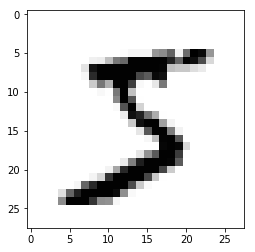

In [39]:
fig, ax = plt.subplots()
ax.imshow(X_train[0].reshape(-1,28), cmap='Greys');

In [40]:
import numpy as np

In [41]:
np.max(X_train[0])

255.0

### Baseline model

If we conceptualize each image sample as a 1-dimensional vector, we can use any multiclass model available. For example, we could simply train a single decision tree:

```python
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print(accuracy_score(y_test, yhat))
```

If you run this, you'll find a single decision tree can classify hand-drawn digits with about 88% accuracy. Pretty good for being so simple. That's the score to beat.

Take a moment to discuss with your partner what each split in the decision tree means, and what it means for a decision tree to classify an image.

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier()
clf.fit(X_train[:10000,:], y_train[:10000])
yhat = clf.predict(X_test)
print(accuracy_score(y_test, yhat))

0.8058


### Logistic Regression with Keras

Maybe the simplest possible model in Keras a neural network with a single unit and no hidden layer:

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
np.random.seed(42)

n_samples, n_feats = X_train.shape

model = Sequential() # sequence of layers

denselayer = Dense(units=1,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='sigmoid')

model.add(denselayer)
```

1. Build this model, and **without training it**, use the `.predict(X_test)` method to predict the output label of the test set. What is the shape of the output of `predict`? Speculate about why this works, even if you haven't trained the model.

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
np.random.seed(42)

n_samples, n_feats = X_train.shape

model = Sequential() # sequence of layers

denselayer = Dense(units=1,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='sigmoid')

model.add(denselayer)

In [44]:
model.predict(X_test).shape

(10000, 1)

> The shape is (10,000,1) because that is one value output per sample in X_test.

> Hmmm, but how can we _predict_ before we train? What are the weights? It would be impossible in a linear regression. (We would get an error, there would be no Betas!)

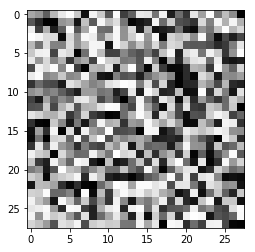

In [45]:
hidden_unit_i = 0
plt.imshow(denselayer.weights[0].numpy()[:,hidden_unit_i].reshape(28,28), cmap="Greys")

> It would seem that they're random

> Let's look at the distribution of the _linear_ outputs

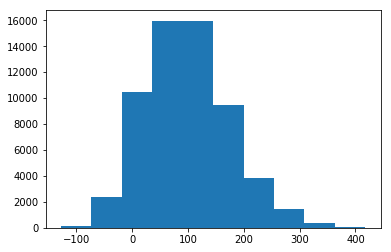

In [46]:
plt.hist(X_train @ model.get_weights()[0]);

> Ok, they're normally distributed... Sooo randomish?

> Let's look at the distribution of the _logistic_ outputs

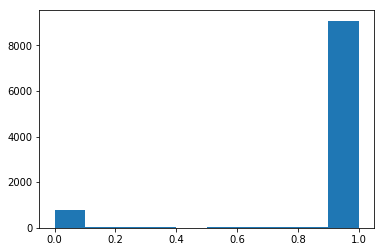

In [47]:
plt.hist(model.predict(X_test));

> the output was random, but then got crunched into the sigmoid function

2. The output of this model is the activation of a single "neuron" (aka "unit"), as a function of all 784 input pixel features. The output of the neuron is `activation_function( m*x+b )`, where `activation_function` is function specified in the `denselayer` layer, and `m` and `b` are the `.weights` and `.bias` members of the layer. Manually obtain the neuron's weight and bias, and use the pseudocode `activation_function( m*x+b )` to calculate the neuron's response to the first test example `X_test[0]`. 

> Output of the model

In [54]:
model.predict(X_test[0].reshape(1,-1))

array([[1.]], dtype=float32)

> output of the model

In [61]:
model.get_layer(index=0).activation

<function tensorflow.python.keras.activations.sigmoid(x)>

In [56]:
model.get_layer(index=0).activation(X_test[0] @ model.get_weights()[0])

<tf.Tensor: id=7415, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

Now, find the output of a logistic regression model using `m` as the `beta` and `X_test[0]` as `x_i`. How to they compare?

In [57]:
def sigma(x):
    return 1 / (1 + 1 / np.exp(x))

In [58]:
sigma(X_test[0] @ model.get_weights()[0])

array([1.], dtype=float32)

> they're the same?!!

3. The current model can't do multiclass prediction - it can only predict a single thing. Let's use it to predict if an image is a '1'. Create a binary label set `yone_train` and `yone_test` for images that are ones, and then train it like this:

```
from tensorflow.keras.metrics import Precision, Recall
model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=[Precision(), Recall()] ) 

model.fit(X_train, yone_train, epochs=10, batch_size=5000, verbose=1,
              validation_split=0.1)
```

Take a look at the `weight` and `bias` parameters of the `denselayer`. Have they changed? Now that you've considered the relationship of this neuron to logistic regression, how would you relate training this model to training a logistic regression model? (Consider taking the neuron's `weight` vector, reshaping it into a square, and rendering an image of it.)

In [23]:
y_train==1

array([False, False, False, ..., False, False, False])

In [24]:
yone_train = y_train==1
yone_test = y_test==1

from tensorflow.keras.metrics import Precision, Recall
model = Sequential() # sequence of layers

denselayer = Dense(units=1,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='sigmoid')

model.add(denselayer)

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=[Precision(), Recall(), 'accuracy'] ) 

model.fit(X_train, yone_train, epochs=10, batch_size=5000, verbose=1,
              validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 1s 24us/sample - loss: 7.8219 - precision: 0.6772 - recall: 0.6810 - accuracy: 0.9271 - val_loss: 0.7380 - val_precision: 0.9238 - val_recall: 0.9429 - val_accuracy: 0.9858
Epoch 2/10
54000/54000 [==============================] - 0s 6us/sample - loss: 0.8713 - precision: 0.9263 - recall: 0.9342 - accuracy: 0.9841 - val_loss: 0.5825 - val_precision: 0.9473 - val_recall: 0.9413 - val_accuracy: 0.9883
Epoch 3/10
54000/54000 [==============================] - 0s 6us/sample - loss: 0.7150 - precision: 0.9351 - recall: 0.9382 - accuracy: 0.9856 - val_loss: 0.4731 - val_precision: 0.9432 - val_recall: 0.9492 - val_accuracy: 0.9887
Epoch 4/10
54000/54000 [==============================] - 0s 6us/sample - loss: 0.6110 - precision: 0.9364 - recall: 0.9439 - accuracy: 0.9864 - val_loss: 0.4052 - val_precision: 0.9422 - val_recall: 0.9571 - val_accuracy: 0.9893
Epoch 5/10
54000/54000 [======

In [25]:
model.weights[0].numpy()[:,hidden_unit_i].reshape(28,28)

array([[-9.51113552e-03, -1.61494240e-02,  4.98741865e-03,
        -1.35306343e-02,  4.09037583e-02,  4.51615341e-02,
        -4.29510474e-02, -1.56362653e-02,  1.70658715e-02,
         4.92255129e-02,  2.76861452e-02, -6.55674934e-03,
         4.98711579e-02, -4.50650230e-02, -3.04171089e-02,
         4.34661247e-02, -4.44931909e-03,  2.75762118e-02,
        -2.60550026e-02,  1.50920190e-02,  2.78774612e-02,
         1.06488839e-02,  4.75630648e-02,  2.05459110e-02,
        -3.53593938e-02,  4.54674400e-02,  2.08733231e-03,
         3.79588716e-02],
       [-4.15684804e-02,  2.19164006e-02, -1.37005933e-02,
        -1.48350000e-02, -3.56351621e-02, -3.73683870e-04,
        -2.82211788e-02, -8.97929817e-03, -2.67670192e-02,
         1.82492286e-02,  1.70883629e-02, -1.70346349e-02,
        -8.50106217e-03,  9.84223909e-04,  1.09250788e-02,
        -3.88185456e-02,  2.40636282e-02, -6.92306599e-03,
        -9.18786856e-04,  8.88562761e-03, -2.61877757e-03,
        -2.38839649e-02, -4.61

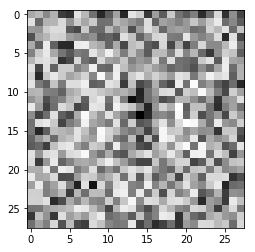

In [26]:
hidden_unit_i = 0
plt.imshow(model.weights[0].numpy()[:,hidden_unit_i].reshape(28,28), cmap="Greys")

> Theres a dark spot in the middle! Looking for that vertical line, and it's very white on the sides.

### Logistic regression in parallel

Keras allows us to perform logistic regression _in parallel_ for a large number of target classes:

```python
np.random.seed(42)

n_samples, n_feats = X_train.shape

model = Sequential() # sequence of layers

denselayer = Dense(units=10,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='sigmoid')

model.add(denselayer)

model.compile(loss='categorical_crossentropy', 
              optimizer="sgd", metrics=["accuracy"] )
```

1. Compile and train this model. What test accuracy does it converge to? Is it good or bad?

In [33]:
np.random.seed(42)

n_samples, n_feats = X_train.shape

model = Sequential() # sequence of layers

denselayer = Dense(units=10,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='sigmoid')

model.add(denselayer)

model.compile(loss='categorical_crossentropy', 
              optimizer="sgd", metrics=["accuracy"] )
from tensorflow.keras.utils import to_categorical
model.fit(X_train, to_categorical(y_train), epochs=10, batch_size=5000, verbose=1,
              validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 1s 24us/sample - loss: 4.0182 - accuracy: 0.1601 - val_loss: 2.3763 - val_accuracy: 0.1882
Epoch 2/10
54000/54000 [==============================] - 1s 14us/sample - loss: 2.3421 - accuracy: 0.1811 - val_loss: 2.2868 - val_accuracy: 0.1870
Epoch 3/10
54000/54000 [==============================] - 1s 13us/sample - loss: 2.2932 - accuracy: 0.1834 - val_loss: 2.2681 - val_accuracy: 0.1892
Epoch 4/10
54000/54000 [==============================] - 1s 10us/sample - loss: 2.2737 - accuracy: 0.1870 - val_loss: 2.2578 - val_accuracy: 0.1917
Epoch 5/10
54000/54000 [==============================] - 1s 10us/sample - loss: 2.2616 - accuracy: 0.1907 - val_loss: 2.2490 - val_accuracy: 0.1953
Epoch 6/10
54000/54000 [==============================] - 1s 10us/sample - loss: 2.2528 - accuracy: 0.1956 - val_loss: 2.2425 - val_accuracy: 0.1995
Epoch 7/10
54000/54000 [==============================] -

In [34]:
model.predict(X_test)[0]

array([1.        , 0.        , 1.        , 1.        , 0.9997985 ,
       1.        , 1.        , 1.        , 0.99997675, 1.        ],
      dtype=float32)

In [35]:
y_test[0]

7

2. Use the model to find a probabilistic prediction on any item in `X_test`. What is the _sum of probabilities_ for every predicted class?

You'll notice the predictions are hot garbage (with an accuracy around 20%), and that the class probabilities for every class sum to more than 1.0.

One solution is to apply a function to the neuron outputs that normalizes the vector such that it's constrained to add up to 1.0, and then on a loss from _that_ function.

In [36]:
model.predict(X_test).sum(axis=0)

array([5870.704 , 6997.9746, 8427.09  , 9522.488 , 9605.1   , 9973.965 ,
       9619.411 , 9409.269 , 9722.523 , 9877.384 ], dtype=float32)

In [37]:
model.predict(X_test)

array([[1.        , 0.        , 1.        , ..., 1.        , 0.99997675,
        1.        ],
       [0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 1.        , 1.        , ..., 0.47325078, 1.        ,
        1.        ],
       ...,
       [1.        , 0.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]], dtype=float32)

3. Change the `activation` argument to "softmax", and retrain the model. What is the test accuracy? What is the sum of classification probabilities for all classes, for a single prediction?

In [38]:
np.random.seed(42)

n_samples, n_feats = X_train.shape

model = Sequential() # sequence of layers

denselayer = Dense(units=10,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='softmax')

model.add(denselayer)

model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=["accuracy"] )
from tensorflow.keras.utils import to_categorical
model.fit(X_train, to_categorical(y_train), epochs=10, batch_size=5000, verbose=1,
              validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 1s 16us/sample - loss: 186.8225 - accuracy: 0.4214 - val_loss: 26.8597 - val_accuracy: 0.7410
Epoch 2/10
54000/54000 [==============================] - 1s 11us/sample - loss: 28.0254 - accuracy: 0.7536 - val_loss: 14.4070 - val_accuracy: 0.8430
Epoch 3/10
54000/54000 [==============================] - 1s 12us/sample - loss: 12.2037 - accuracy: 0.8477 - val_loss: 10.0931 - val_accuracy: 0.8645
Epoch 4/10
54000/54000 [==============================] - 1s 13us/sample - loss: 20.5367 - accuracy: 0.7897 - val_loss: 18.4241 - val_accuracy: 0.8105
Epoch 5/10
54000/54000 [==============================] - 1s 12us/sample - loss: 16.3915 - accuracy: 0.8130 - val_loss: 7.6938 - val_accuracy: 0.8898
Epoch 6/10
54000/54000 [==============================] - 1s 11us/sample - loss: 8.8445 - accuracy: 0.8723 - val_loss: 10.2794 - val_accuracy: 0.8470
Epoch 7/10
54000/54000 [======================

Extra credit: train with a large `batch` argument in `.fit`, and make pictures of the unit weights reshaped into 28x28 images.

### Perceptrons: logistic regression with hidden features

A perceptron is an architecture whereby an input is classified into a number of features; features that are actually unknown when model training begins. Then, logistic regression (or softmax regression) using the _hidden features_ as inputs is used to find the final class probabilities. This architecture is called a "perceptron", "multiplayer perceptron", or "MLP". Here's how to define an MLP with 300 neurons in one hidden layer, using Keras:

```python
np.random.seed(42)

n_samples, n_feats = X_train.shape

model = Sequential() # sequence of layers

hidden_units = 300
n_classes = 10

hidden_layer = Dense(units=hidden_units,
                input_dim=n_feats,
                kernel_initializer='constant',
                activation='sigmoid')

output_layer = Dense(units=n_classes,
                input_dim=hidden_units,
                kernel_initializer='uniform',
                activation='softmax')

model.add(hidden_layer)
model.add(output_layer)
```

1. Compile and train this model on the MNIST dataset. The 'adam' optimizer tends to do well. What kind of accuracy do you get? 

In [39]:
np.random.seed(42)

n_samples, n_feats = X_train.shape

model = Sequential() # sequence of layers

hidden_units = 300
n_classes = 10

hidden_layer = Dense(units=hidden_units,
                input_dim=n_feats,
                kernel_initializer='constant',
                activation='sigmoid')

output_layer = Dense(units=n_classes,
                input_dim=hidden_units,
                kernel_initializer='uniform',
                activation='softmax')

model.add(hidden_layer)
model.add(output_layer)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])
model.fit(X_train, to_categorical(y_train))

60000/60000 [==============================] - 17s 283us/sample - loss: 0.4297 - accuracy: 0.8869


2. Vary the hyperparameters. Choose differnet activations, kernal initializers, hidden units, optimizers, and optimizer parameters. To access optimizer parameters, instantiate optimizer objects from `tensorflow.keras.optimizers`. Can you get a better accuracy than 94%?

This task might feel a little like looking for a needle in a haystack.  Perhaps you can think of an automated approach instead of a manual brute force search? (but with some intuition the brute force search will get you there, too.)  Keras has a [wrapper](https://keras.io/scikit-learn-api/) for the scikit-learn API where you can interface with GridSearch.  See this [blog post.](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)

In [41]:
np.random.seed(42)

n_samples, n_feats = X_train.shape

model = Sequential() # sequence of layers

hidden_units = 300
n_classes = 10

hidden_layer = Dense(units=hidden_units,
                input_dim=n_feats,
                kernel_initializer='constant',
                activation='sigmoid')

output_layer = Dense(units=n_classes,
                input_dim=hidden_units,
                kernel_initializer='uniform',
                activation='softmax')

model.add(hidden_layer)
# model.add(Dense(units=hidden_units,
#                 input_dim=hidden_units,
#                 kernel_initializer='uniform',
#                 activation='softmax'))
model.add(output_layer)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])
model.fit(X_train, to_categorical(y_train), epochs=10)

Epoch 1/10
60000/60000 [==============================] - 21s 346us/sample - loss: 0.4333 - accuracy: 0.8850
Epoch 2/10
60000/60000 [==============================] - 16s 263us/sample - loss: 0.3153 - accuracy: 0.9107
Epoch 3/10
60000/60000 [==============================] - 15s 250us/sample - loss: 0.2869 - accuracy: 0.9154
Epoch 4/10
60000/60000 [==============================] - 15s 255us/sample - loss: 0.2676 - accuracy: 0.9199
Epoch 5/10
60000/60000 [==============================] - 27s 446us/sample - loss: 0.2516 - accuracy: 0.9247
Epoch 6/10
60000/60000 [==============================] - 27s 455us/sample - loss: 0.2492 - accuracy: 0.9257
Epoch 7/10
60000/60000 [==============================] - 23s 391us/sample - loss: 0.2422 - accuracy: 0.9270
Epoch 8/10
60000/60000 [==============================] - 24s 401us/sample - loss: 0.2398 - accuracy: 0.9273
Epoch 9/10
60000/60000 [==============================] - 24s 394us/sample - loss: 0.2210 - accuracy: 0.9324
Epoch 10/10
60000/6

3. When you have a very good accuracy, make a picture of the weights associated with the hidden layers.

Hint: do this, 
```python
hidden_unit_i = 0
plt.imshow(hidden_layer.weights[0].numpy()[:,hidden_unit_i].reshape(28,28))
```

Speculate on what this might mean.

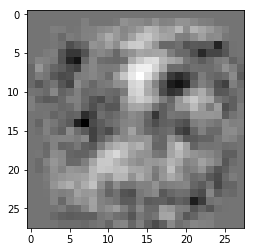

In [55]:
hidden_unit_i = 0
plt.imshow(hidden_layer.weights[0].numpy()[:,hidden_unit_i].reshape(28,28), cmap="Greys")

## Installation for PCs with NVIDIA GPUs that wish to use the GPU to speed up training.  

1) Go [here](https://github.com/NVIDIA/nvidia-docker) and follow the directions to install `nvidia-docker`.

2) Check that it works:  
   ```bash
   $ docker run --gpus all nvidia/cuda:9.0-base nvidia-smi
   ```

3) Download an image, make a container and a volume:
   ```
   $ cd ~
   $ docker run --gpus all -it --name tensorflow-gpu -p 8888:8888 -v "$PWD":/tf tensorflow/tensorflow:latest-gpu-py3-jupyter
   ```

As discussed in Part I, you can work with the container in a Jupyter notebook or from terminal.